# Investment Comp Screener

Premia/ Discount (P/D)

Sector 3 year Z Score (S3ZS)

Company 3 year Z Score (C3ZS)

In [136]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
import os
import glob
import re
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF

In [137]:
def calc_ecdf(data):
    #low is good
    ecdf= ECDF(data)
    current_perc = ecdf(data[-1])
    
    return(current_perc)

In [138]:
def color_negative_red(value):
    """
      Colors elements in a dateframe
      green if positive and red if
      negative. Does not color NaN
      values.
      """

    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

In [139]:
def Z_score(data):
    # not including the current observation
    std = data.iloc[:-1].std()
    mean = data.iloc[:-1].mean()
    Z = (data[-1:] - mean)/std
    return Z
    

## Data Import

In [140]:
path = "holding_companies_data"
arr = [x for x in os.listdir(path) if x.endswith(".csv")]

In [141]:
for f in arr:
    print(f)

2020-12-29_trac b_pris_historik.csv
2020-12-29_lund b_pris_historik.csv
2020-12-29_vnv_pris_historik.csv
2020-12-29_svol b_pris_historik.csv
2020-12-29_indu c_pris_historik.csv
2020-12-29_inve b_pris_historik.csv
2020-12-29_cred a_pris_historik.csv
2020-12-29_ores_pris_historik.csv
2020-12-29_lato b_pris_historik.csv
2020-12-29_kinv b_pris_historik.csv
2020-12-29_bure_pris_historik.csv


In [142]:
for k in arr:
    if "trac" in k:
        traction = pd.read_csv(os.path.join(path,k))
    if "lund" in k:
        lundbergs = pd.read_csv(os.path.join(path,k))
    if "hav" in k:
        havsfrun = pd.read_csv(os.path.join(path,k))
    if "ores" in k:
        oresund = pd.read_csv(os.path.join(path,k))
    if "indu" in k:
        industri = pd.read_csv(os.path.join(path,k))
    if "svol" in k:
        svolder = pd.read_csv(os.path.join(path,k))
    if "bure" in k:
        bure = pd.read_csv(os.path.join(path,k))
    if "cred" in k:
        creades = pd.read_csv(os.path.join(path,k))
    if "inve" in k:
        investor = pd.read_csv(os.path.join(path,k))
    if "kinv" in k:
        kinnevik = pd.read_csv(os.path.join(path,k))
    if "vnv" in k:
        vnv = pd.read_csv(os.path.join(path,k))
    if "naxs" in k:
        naxs = pd.read_csv(os.path.join(path,k))
    if "lato" in k:
        latour = pd.read_csv(os.path.join(path,k))
    

## Calculate Metrics

In [143]:
look_back = 3*252 #3 years
ST_look_back = 5


#companies = [traction, lundbergs, havsfrun, oresund, industri,
#             svolder, bure, creades, investor, kinnevik, vnv, naxs,latour]

#companies_names = ['Traction', 'Lundbergsföretagen', 'Havsfrun Investment', 'Öresund', 'Industrivärden',
#            'Svolder', 'Bure', 'Creades', 'Investor', 'Kinnevik', 'VNV Global', 'NAXS','Latour']

companies = [traction, lundbergs, oresund, industri,
             svolder, bure, creades, investor, kinnevik, vnv,latour]

companies_names = ['Traction', 'Lundbergsföretagen', 'Öresund', 'Industrivärden',
             'Svolder', 'Bure', 'Creades', 'Investor', 'Kinnevik', 'VNV Global','Latour']


for comp in companies:
    
    comp['DATUM'] = pd.to_datetime(comp['DATUM'])
    comp.set_index(['DATUM'], inplace=True, drop=True)
    comp['P/D']=comp['PRIS']/comp['BERÄKNAT_SUBSTANSVÄRDE'] - 1
    



In [144]:
#high DSSP and HIDI is good

AVG_DISC = pd.DataFrame(latour['PRIS'].copy())
AVG_DISC['PRIS'] = 0
AVG_DISC.columns = ['AVG_DISC']

for comp in companies:

    AVG_DISC['AVG_DISC'] = AVG_DISC['AVG_DISC'] + comp['P/D']

AVG_DISC = AVG_DISC/len(companies)

for comp in companies:
    comp['SPREAD'] = comp['P/D'] - AVG_DISC['AVG_DISC']
    #comp['DSSP'] = -comp['SPREAD'].rolling(look_back).apply(lambda x: calc_ecdf(x),raw=False) + 1
    comp['S3ZS'] = -comp['SPREAD'].rolling(look_back).apply(lambda x: Z_score(x),raw=False) 
    #comp['HIDI'] = -comp['R/P'].rolling(look_back).apply(lambda x: calc_ecdf(x),raw=False) + 1
    comp['C3ZS'] = -comp['P/D'].rolling(look_back).apply(lambda x: Z_score(x),raw=False)
    comp['MOM'] = (comp['PRIS'].pct_change(252) + comp['PRIS'].pct_change(126) + comp['PRIS'].pct_change(63))/3
    comp['NAV MOM'] = (comp['BERÄKNAT_SUBSTANSVÄRDE'].pct_change(252) + comp['BERÄKNAT_SUBSTANSVÄRDE'].pct_change(126) + comp['BERÄKNAT_SUBSTANSVÄRDE'].pct_change(63))/3
    comp['ST'] = comp['PRIS'].pct_change(ST_look_back)
    
    

In [145]:
INV_COMP = None

for comp in companies:
    
    INV_COMP = pd.concat([INV_COMP, comp.tail(1)], axis = 0)

INV_COMP['Company'] = companies_names
INV_COMP.set_index(['Company'], inplace=True, drop=True)



In [146]:
INV_COMP['VRANK'] = (INV_COMP['P/D'].rank() + INV_COMP['S3ZS'].rank(ascending = False) +
 INV_COMP['C3ZS'].rank(ascending = False)).rank()



INV_COMP['MRANK'] = (INV_COMP['MOM'].rank(ascending = False)+INV_COMP['NAV MOM'].rank(ascending = False)).rank()

INV_COMP['CRANK'] = (INV_COMP['VRANK'] + INV_COMP['MRANK']).rank()


compact = ['P/D', 'C3ZS', 'S3ZS', 'MOM', 'NAV MOM', 'VRANK', 'MRANK', 'CRANK', 'ST']

INV_COMP = INV_COMP[compact]

INV_COMP['P/D']=-INV_COMP['P/D']

In [147]:
average = pd.DataFrame(INV_COMP.mean(axis = 0)).transpose()
average.index = ['Average']
INV_COMP = pd.concat([INV_COMP, average], axis = 0)

## Display Results

In [148]:
th_props = [
  ('font-size', '16px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


# Set CSS properties for td elements in dataframe
td_props = [('font-size', '16px'), ('text-align', 'center')]

# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props)
]

cm_low_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(INV_COMP.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
cm_high_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(INV_COMP.columns), as_cmap=True)

INV_COMP_VIEW = (INV_COMP.style
    .applymap(color_negative_red, subset=['P/D', 'MOM', 'NAV MOM'])
    .background_gradient(axis = 0 ,subset = ['S3ZS', 'C3ZS'],cmap=cm_high_good)
    .background_gradient(axis = 0 ,subset = ['VRANK', 'MRANK','CRANK', 'ST'],cmap=cm_low_good)
    #.set_caption('Performance Metrics')
    .format({'P/D': "{:.1%}", 'S3ZS': "{:.2f}", 'C3ZS': "{:.2f}", 'MOM':"{:.1%}", 'NAV MOM': "{:.1%}",
            'Sortino': "{:.2f}", 'MAR': "{:.2f}", 'VRANK': "{:.0f}", 'MRANK': "{:.0f}", 'CRANK': "{:.0f}",'ST':"{:.1%}"})
    .set_table_styles(styles))

In [149]:
INV_COMP_VIEW

,P/D,C3ZS,S3ZS,MOM,NAV MOM,VRANK,MRANK,CRANK,ST
Traction,3.7%,-0.25,1.88,3.6%,8.5%,3,9,6,4.8%
Lundbergsföretagen,1.3%,0.35,2.51,2.7%,15.2%,2,8,2,3.1%
Öresund,4.8%,1.45,2.56,0.4%,7.5%,1,11,6,1.3%
Industrivärden,4.6%,-1.97,1.48,17.8%,9.4%,5,6,5,2.7%
Svolder,-6.1%,-2.01,0.70,36.3%,29.0%,7,3,2,9.7%
Bure,-20.4%,-1.51,-0.73,23.4%,14.8%,8,4,8,4.8%
Creades,-55.7%,-1.45,-1.14,46.6%,40.6%,10,1,4,7.3%
Investor,15.5%,-1.51,1.88,11.6%,6.8%,4,10,10,3.2%
Kinnevik,-5.2%,-2.59,-0.50,52.2%,22.4%,8,2,3,1.1%
VNV Global,-36.5%,-5.35,-3.90,71.2%,-5.2%,11,5,11,13.6%


In [119]:
data = yf.download('GLD')

[*********************100%***********************]  1 of 1 completed


In [120]:
ret = data.pct_change(1)

In [133]:
vol_corr = ret['Adj Close'].rolling(66).corr(ret['Volume'])

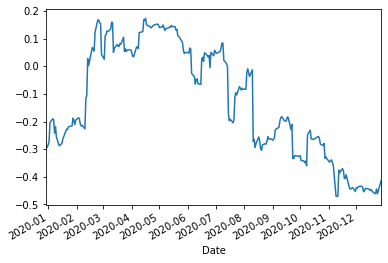

In [135]:
vol_corr[-252:].plot();